In [1]:
pip install tweepy

#Import all libraries and modules needed

In [23]:
# for extracting data 
import tweepy
import time

In [99]:
# general purpose
import pandas as pd
import csv
import itertools
from collections import Counter
import numpy as np

In [25]:
#network and visualization purpose
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community


# Scraping Twitter Data

## Getting API with Developer Access tokens


In [7]:

# Enter your own credentials obtained from your developer account
ACCESS_TOKEN = "1449075799798157313-iyEb4jYTbxhZDFetW6ftsEOCVTm1IB"
access_token_secret = "drmcBsnG85OypPmEI0CwSaANqM8UP6Zc131CxMbvYB4hi"

api_key = "tBz9nb1auii6jpniGMmgN2yqO"
api_key_secret = "olMh38421tcVuU61wPlkPkObl3N8Sn6v2M3Ah5WplOQvFQcPH7"

auth = tweepy.OAuthHandler(consumer_key = api_key, consumer_secret = api_key_secret)
auth.set_access_token(ACCESS_TOKEN, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

## To perform Extraction

In [ ]:
# Scraping Data of Tweets using Hashtags. And save them in a CSV file.

# reference : https://www.geeksforgeeks.org/extracting-tweets-containing-a-particular-hashtag-using-python/?ref=gcse


def printtweetdata(n, ith_tweet):
    print()
    print(f"Tweet {n}:")
    print(f"Username:{ith_tweet[0]}")
    print(f"Description:{ith_tweet[1]}")
    print(f"Location:{ith_tweet[2]}")
    print(f"Following Count:{ith_tweet[3]}")
    print(f"Follower Count:{ith_tweet[4]}")
    print(f"Total Tweets:{ith_tweet[5]}")
    print(f"Retweet Count:{ith_tweet[6]}")
    print(f"Tweet Text:{ith_tweet[7]}")
    print(f"Hashtags Used:{ith_tweet[8]}")


# function to perform data extraction
def scrape(words, date_since, date_until, numtweet, api):
    
    # Creating DataFrame using pandas
    db = pd.DataFrame(columns=['username', 'description', 
                               'location', 'following',
                            'followers', 'totaltweets', 
                            'retweetcount', 'text', 
                            'hashtags']) # 'retweeters'])
    
    # We are using .Cursor() to search through twitter for the required tweets.
    # The number of tweets can be restricted using .items(number of tweets)
    tweets = tweepy.Cursor(api.search, q=words, lang="en",
                        since=date_since, tweet_mode='extended').items(numtweet)
    print(tweets)
    # .Cursor() returns an iterable object. Each item in
    # the iterator has various attributes that you can access to
    # get information about each tweet
    list_tweets = [tweet for tweet in tweets]
    
    # Counter to maintain Tweet Count
    i = 1
    
    # we will iterate over each tweet in the list for extracting information about each tweet
    for tweet in list_tweets:
        tweet_id = tweet.user.id
        username = tweet.user.id_str
        description = tweet.user.description
        location = tweet.user.location
        following = tweet.user.friends_count
        followers = tweet.user.followers_count
        totaltweets = tweet.user.statuses_count
        retweetcount = tweet.retweet_count
        hashtags = tweet.entities['hashtags']
        # retweeters_list = retweet_users_from_tweet_id(tweet_id, api) #for every tweetid, go fetch retweeter's screen name.
         
        # Retweets can be distinguished by a retweeted_status attribute,
        # in case it is an invalid reference, except block will be executed
        try:
            text = tweet.retweeted_status.full_text
        except AttributeError:
            text = tweet.full_text
        hashtext = list()
        for j in range(0, len(hashtags)):
            hashtext.append(hashtags[j]['text'])
        
        # Here we are appending all the extracted information in the DataFrame
        ith_tweet = [username, description, location, following,
                    followers, totaltweets, retweetcount, text, hashtext] #, retweeters_list]
        db.loc[len(db)] = ith_tweet
        
        # Function call to print tweet data on screen
        # printtweetdata(i, ith_tweet)
        # i = i+1
    filename = 'Scraped_tweets.csv'
    
    # we will save our database as a CSV file.
    db.to_csv(filename)
    return list_tweets
    

if __name__ == '__main__':
       
    # Enter Hashtag and initial date
    # print("Enter Twitter HashTag to search for")
    # words = input()
    # print("Enter Date since The Tweets are required in yyyy-mm-dd")
    # date_since = input()
    
    date_since = '2020-04-10'
    date_until = '2020-06-30'
    words = '#dalitlivesmatter'

    print("Twitter HashTag to searched for : ", words)
    # print("Date since The Tweets taken in yyyy-mm-dd : ", date_since)
    # print("Date until The Tweets taken in yyyy-mm-dd : ", date_until)

    # number of tweets you want to extract in one run
    numtweet = 200
    list_tweets = scrape(words, date_since, date_until, numtweet, api)
    print('Scraping has completed!')
  

In [ ]:
# data = pd.read_csv('Scraped_tweets.csv') 

### Scraping Retweeters List 


After this, the retweeters will be retrieved per every Tweet Id from the List of Tweets. As more retweeters are found for every tweet id, the **retweets information** will be saved in another list, its counter (retweet count) will be maintained. At last, this information will be added in the main Data frame file created from Scraped File.

In [ ]:
# to find retweeters for each tweet id scraped 


def retweet_auth(id, api):
    """this functions extracts retweeters information and saves them in a list"""
    user_ids = []
    for page in tweepy.Cursor(api.retweeters, id = id, count = 200).pages():
        user_ids.extend(page)
        time.sleep(10)

    return user_ids

all_retweets = []
cnt = 0

for i in list_tweets:
    all_retweets.append(retweet_auth(i.id,api))
    cnt = cnt+1
    print(cnt)
    tweetFetched = api.get_status(i.id)
    print(tweetFetched.retweet_count)
    print(i.id, retweet_auth(i.id,api)) 
    #prints count, tweetfetched-retweet-count then tweeter id, then user id of retweeters
    rt = pd.DataFrame(columns= ['allretweets', 'fetchedtweets', 'tweetid'])
    rt['allretweets'] = all_retweets
    rt['fetchedtweets'] = tweetFetched
    rt['tweetid'] = i.id 


In [ ]:
"""
# Saving Retweets for further use in case the program crashes wrong 
# save in csv file just because it is slow and will be harder to retrieve later, 
# especially if itcrosses the maximum limit 
with open('rt', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow('all_retweets')
    write.writerows(all_retweets)
"""

# Reading the CSV file created for Scraped Data. 

In [ ]:
# READ CSV FILE AND ADD RETWEETERS INFORMATION INTO CSV

data = pd.read_csv('Scraped_tweets.csv') 
data = data.drop('Unnamed: 0', axis = 1) #drop first column
data['retweeters'] = all_retweets
data.head()

In [32]:
#IF Upload File locally in Colab

data = pd.read_csv('Scraped_tweets.csv') 
data = data.drop('Unnamed: 0', axis = 1) #drop first column
data.head()

,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags
0,1097144737109340161,Freelancer reporter / R.T.I 'Activist / Social...,"Maharashtra, India",1037,344,10812,2,"Dalit youth dies in TN’s Kanyakumari, kin alle...",['DalitLivesMatter']
1,1287027988962275328,NaN,NaN,1106,654,10192,2,"If u keep silent now, then it would be next in...",['DalitLivesMatter']
2,238889026,Political Party- BSP || Religion- Buddhism,NaN,1203,847,9279,2,"Dalit youth dies in TN’s Kanyakumari, kin alle...",['DalitLivesMatter']
3,160836619,An Ardent ..AGGRESSIVE #THALA #DADA & #Yuva Fa...,"Bengaluru, India",1408,1806,121727,2,"If u keep silent now, then it would be next in...",['DalitLivesMatter']
4,245474233,"| Thinker | Analyst | Believes in liberty, equ...",🇮🇳,800,9714,61636,2,"Dalit youth dies in TN’s Kanyakumari, kin alle...",['DalitLivesMatter']


# Exploratory Data Analysis

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   username      200 non-null    int64 
 1   description   156 non-null    object
 2   location      126 non-null    object
 3   following     200 non-null    int64 
 4   followers     200 non-null    int64 
 5   totaltweets   200 non-null    int64 
 6   retweetcount  200 non-null    int64 
 7   text          200 non-null    object
 8   hashtags      200 non-null    object
dtypes: int64(5), object(4)
memory usage: 14.2+ KB


In [36]:
data.describe()

,username,following,followers,totaltweets,retweetcount
count,2.000000e+02,200.000000,200.00000,200.000000,200.000000
mean,7.838265e+17,1573.030000,3239.66500,34172.090000,91.200000
std,5.915307e+17,5331.630284,12322.89328,81187.009416,110.222935
min,1.657958e+07,0.000000,2.00000,28.000000,0.000000
25%,2.810946e+09,204.000000,83.00000,3360.750000,83.000000
50%,1.093104e+18,499.000000,293.00000,9418.500000,83.000000
75%,1.280690e+18,1272.250000,838.75000,25919.250000,114.000000
max,1.454507e+18,70400.000000,115381.00000,720122.000000,838.000000


In [41]:
# Small EDA

print("Uniques Usernames(id) texts from file are : ", len(data['username'].unique()))
print("Uniques Tweet texts from file are : ",  len(data['text'].unique()))
print("Uniques Hashtag texts from file are : ", len(data['hashtags'].unique()))

Uniques Usernames(id) texts from file are :  197
Uniques Tweet texts from file are :  36
Uniques Hashtag texts from file are :  26


In [44]:
print("Uniques Hashtag set are : ", data['hashtags'].unique())

# Getting a list of Tags for Network Experimentations

# tags = []
# for i in [data['hashtags'].unique()]: 
#   for j in i:
#     tags.append(j)

# tags
# len(tags)

Uniques Hashtag set are :  ["['DalitLivesMatter']" "['muslim', 'DalitLivesMatter']"
 "['crushthecaste', 'DalitLivesMatter']" "['Jharkhand']"
 "['Assam', 'NRC', 'JaiBhim', 'DalitLivesMatter']" '[]'
 "['DalitLivesMatter', 'Dalit']" "['DeepaPMohanan', 'DalitLivesMatter']"
 "['AFieldOfFlowers']"
 "['India', 'RSS', 'Dalit', 'Fascist', 'DalitLivesMatter', 'Dalits', 'Hindu', 'HinduRashtra', 'ModiHoshMeinAao', 'ModiMadeDisaster', 'Pakistan']"
 "['Sikhs', 'DalitLivesMatter', 'Punjab', 'harijan', 'Dalit', 'schedulecaste']"
 "['UttarPradesh']"
 "['India', 'minorityrights', 'asia', 'peaceforasia', 'Karnataka', 'violence', 'rightwing', 'muslims', 'southasia', 'lynching', 'humanrights', 'DalitLivesMatter', 'Hindutva']"
 "['MuslimLivesMatter', 'DalitLivesMatter', 'TribalLivesMatter']"
 "['JusticeForDeepaPMohanan', 'dalitlivesmatter']" "['deepamohanan']"
 "['deepamohanan', 'DalitLivesMatter', 'JaiBhim', 'stopcastediscrimination']"
 "['DeepaPMohanan', 'Dalitlivesmatter']"
 "['CasteDiscrimination', 'Dal

# Arranging Data for Network

In [ ]:
# getting all retweeters details and adding it into file

"""
All unique users are read to be saved as nodes, 
and their relationships to other users are read into an Edges List.

"""

author = []
for i in data['username']:
    author.append(api.get_user(i).id)

data['username'] = author
all_authors = list(data['username'].unique())
edge = []
for i in range(len(data['username'])):
    for j in data.iloc[i,-1]:
        if(j in all_authors):
            edge.append([data.iloc[i,1],j])

In [ ]:
# saving EDGE information in File

data.to_csv('finaldata.csv')
author_info = pd.DataFrame(columns = author)
author_info.to_csv('all_authors.csv')
edge_info = pd.DataFrame(columns = edge)
edge_info.to_csv('edges.csv')

# Defining Network

In [ ]:
# GET EDGE INFORMATION INTO A DATAFRAME
graph_data = pd.DataFrame(edge, columns = ['src','tar'])
graph_data.info()
# MAKE A GRAPH 
g = nx.from_pandas_edgelist(graph_data, source='src', target='tar')
nx.draw_spring(g)
# Save the graph into a file for convenience
nx.write_gexf(g, "twitterGraph-date.gexf")

'Graph with 102 nodes and 92 edges'

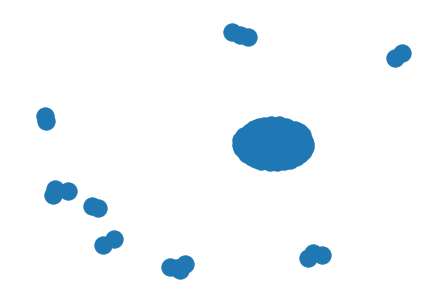

In [55]:
# CAN BE RUN FROM HERE

import networkx as nx # Import command in case program is implemented from here

g = nx.read_gexf('/content/twitter_10Nov.gexf')
nx.draw_spring(g)
nx.info(g)

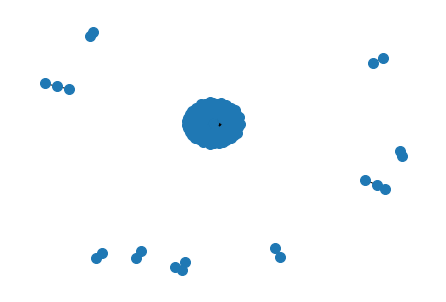

In [58]:
layout = nx.spring_layout(g)
nx.draw(g, pos = layout, with_labels = False, node_size = 100)

# Structural Measures

In [74]:
coeff = nx.clustering(g)
print("[First] Five Coefficients of nodes are : ", 
      dict(itertools.islice(coeff.items(), 5)) )# Commented for space Saving
avg_coeff = nx.average_clustering(g)
print("\nAverage Coefficient of network : ", avg_coeff)

"""Degree distribution"""

degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
dmax = max(degree_sequence)
dmin = min(degree_sequence)
print('dmax: ', dmax, '\ndmin: ', dmin)

[First] Five Coefficients of nodes are :  {'160836619': 0, '1287027988962275328': 0, '245474233': 0, '1097144737109340161': 0, '238889026': 0}

Average Coefficient of network :  0.0
dmax:  80 
dmin:  1


In [84]:
#len(degree_sequence) 
#set(degree_sequence)

In [79]:
"""CONNECTED COMPONENTS"""

n_CC = nx.number_connected_components(g) #all connected components
print("Number of connected Components are: ", n_CC)

largest_CC = max(nx.connected_components(g), key=len) #largest connected component
print("largest connected Components are: ", largest_CC)

CC = nx.connected_components(g) #Generates a sorted list of connected components, largest first.
S = [g.subgraph(c).copy() for c in nx.connected_components(g)] #To create the induced subgraph of each component.

# SCC = nx.strongly_connected_components(g) #only for directed
# WCC= nx.weak_connected_components(g)  #only for directed
## Source : NetworkX documentation

Number of connected Components are:  10
largest connected Components are:  {'803164752', '1110230983595319296', '36367097', '1214254712943284225', '2971786675', '815449844', '1193156402170064896', '361546225', '4568287993', '971099892662726656', '1268081353645588483', '1152322252697817088', '3221665748', '1584491821', '1135048602433142784', '1444195910351613956', '1266049035640565761', '721710751849803776', '3799724953', '1065570487219060737', '354777690', '791891815607697408', '100176738', '1080148340489150464', '1393585343396515846', '969874080', '3097146398', '585347033', '274905437', '1001364202135552000', '1194698046094761984', '1556076211', '1418587000349741057', '1107208078489845760', '1930273044', '2552962878', '983982521514897413', '1036137712640815104', '1100777971646906368', '1433725358', '1130282947951489024', '256506416', '751568942', '1867376347', '1093024846299127808', '909777938333163520', '2337828977', '1297902323834839040', '1093183520544043009', '1112374922423291904'

In [68]:
"""Centrality measures"""

closeness =  nx.closeness_centrality(g)
betweenness =  nx.betweenness_centrality(g)
eigen_centrality = nx.eigenvector_centrality(g)

print('\n Closeness: ', closeness, 
      '\n Betweenness: ', betweenness,
      '\n Eigen_centrality: ', eigen_centrality)


 Closeness:  {'160836619': 0.009900990099009901, '1287027988962275328': 0.009900990099009901, '245474233': 0.019801980198019802, '1097144737109340161': 0.013201320132013201, '238889026': 0.013201320132013201, '1289836784285896705': 0.009900990099009901, '141150560': 0.009900990099009901, '16579578': 0.009900990099009901, '1161175273867366401': 0.009900990099009901, '1344540212702007297': 0.019801980198019802, '2321958656': 0.013201320132013201, '1423159146325499905': 0.013201320132013201, '1579413182': 0.009900990099009901, '1448657427184828426': 0.009900990099009901, '1397573779241402370': 0.019801980198019802, '1406527272798941185': 0.013201320132013201, '1318843637761937410': 0.013201320132013201, '1347232843919880192': 0.009900990099009901, '2207822833': 0.009900990099009901, '56343974': 0.009900990099009901, '506556937': 0.009900990099009901, '971099892662726656': 0.7920792079207921, '945525097867235328': 0.3985304190796438, '1036137712640815104': 0.3985304190796438, '2267513971'

In [70]:
print( '\n Unique values for Betweenness: ', set(closeness.values()),
      '\n Unique values for Betweenness: ', set(betweenness.values()),
      '\n Unique values for Eigenvector Centrality: ', set(eigen_centrality.values()))


 Unique values for Betweenness:  {0.7920792079207921, 0.3985304190796438, 0.009900990099009901, 0.013201320132013201, 0.019801980198019802} 
 Unique values for Betweenness:  {0.0, 0.6257425742574257, 0.00019801980198019803} 
 Unique values for Eigenvector Centrality:  {1.7225159846750509e-38, 0.7071106135239729, 0.07905651303353743, 4.471265958103417e-34, 3.1616624794634915e-34}


## Visualization of Structural Properties

In [85]:
print('--- Degree distribution information ---')

--- Degree distribution information ---


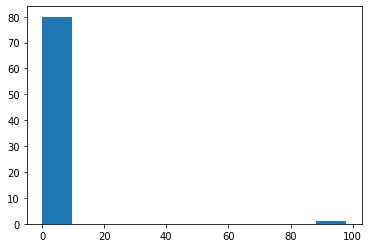

In [98]:
def plot_degree_dist(G):
    # degrees = [G.degree(n) for n in G.nodes()]
    degree_freq = nx.degree_histogram(g)
    degrees = range(len(degree_freq))
    plt.hist(degree_freq)
    plt.show()

plot_degree_dist(g)

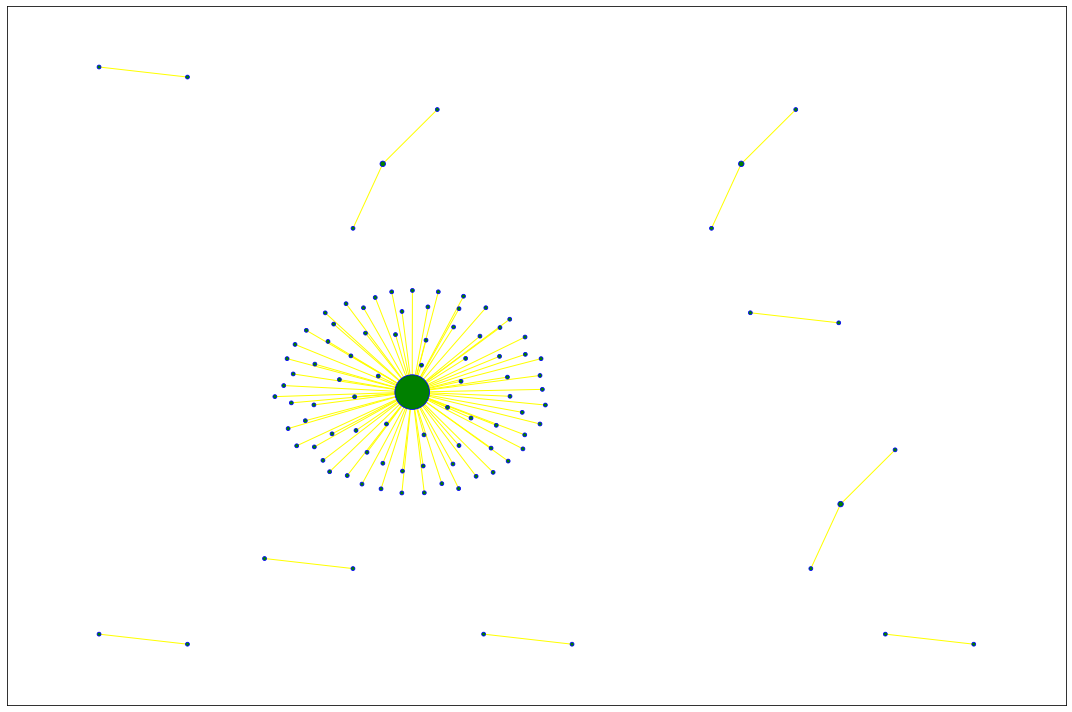

In [105]:
# Plot actual graph of network

plt.figure(num=None, figsize=(15, 10), dpi=None)
layout = nx.nx_pydot.graphviz_layout(g)

color_map = ['green']
node_deg = nx.degree(g)
nx.draw_networkx(
    g,
    node_size= [int(deg[1])*15 for deg in node_deg],
    arrowsize= 5,
    linewidths=0.8,
    pos=layout,
    edge_color='yellow',
    edgecolors='blue',
    node_color=color_map,
    with_labels=False
    #font_size=35
    )

plt.tight_layout()

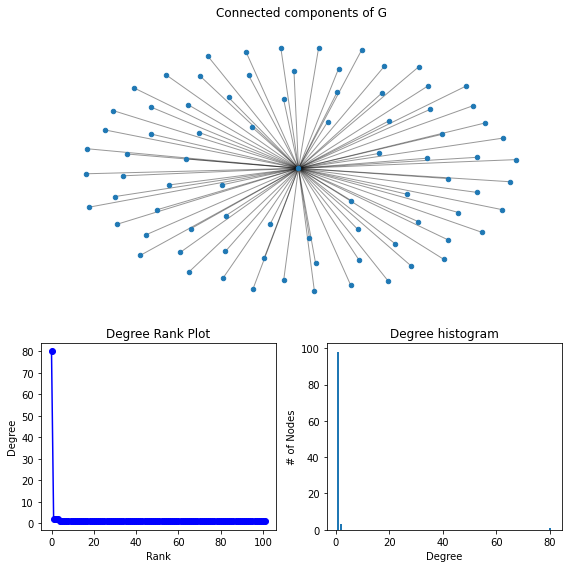

In [107]:
# https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree.html

# Plot degree distribution plt

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)
ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(g), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

# Community Detection 

Following are 3 approaches to form communities. Motive to get this was only to see how many nodes [amongst the very limited data] were being covering the network. 

## Girvan  Newman

In [125]:
communities_generator = community.girvan_newman(g)
top_level_communities = next(communities_generator)
top_level_communities = sorted(map(sorted, top_level_communities))

# Find the number of communities
communities = top_level_communities
print(f" girvan newman {len(communities)} communities.")

# communities = top_level_communities
# communities = next_level_communities # or 

 girvan newman 11 communities.


## Label Propagation 

In [119]:
lpa_comm = nx.algorithms.community.label_propagation.label_propagation_communities(g)
# Find the number of communities
communities = lpa_comm
print(f" lpa {len(communities)} communities.")

 lpa 10 communities.


## Greedy Approach

In [120]:
greedy_comm = community.modularity_max.greedy_modularity_communities(g, weight=None, resolution=1)
# Find the number of communities
communities = greedy_comm
print(f"greedy {len(communities)} communities.")

greedy 10 communities.


## Visualizing Communities

In [123]:
pos = nx.spring_layout(g)
colors = ["violet", "black", "orange", "cyan", "blue", "green", "yellow", "indigo", "pink", "red", "gray"]

In [133]:
def draw_communities(communities) :
  for i in range(len(communities)):
    graph = communities[i]
    node_list = [node for node in graph]
    nx.draw(g, pos, nodelist=node_list, node_color=colors[i%10], node_size=50, alpha=0.8)

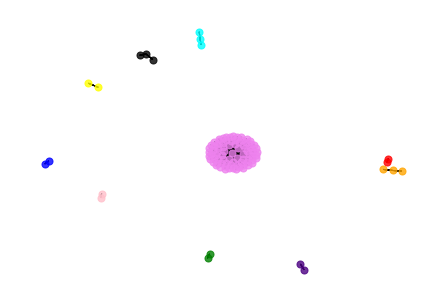

In [136]:
draw_communities(greedy_comm)

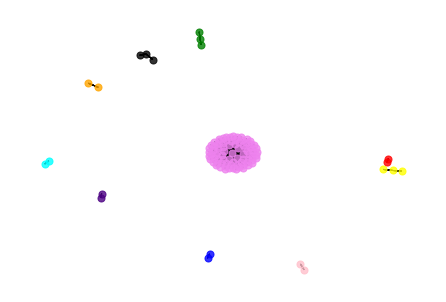

In [135]:
draw_communities(top_level_communities)